In [31]:
import brian2 as b
from brian2.units import (amp, cm, ms, mV, mvolt, nS, ohm, pA, siemens, uF, um,
                          uS, Hz)
from dendrify import Dendrite, NeuronModel, Soma

# Model params
GL = 60*uS/(cm**2)  # specific resistance
CM = 1*uF/cm**2    # specific leakage conductance
RI = 200*ohm*cm    # intracellular resistivity (axial resistance)
EL = -65*mV    # resting potential

# Synaptic params
G_AMPA = 1.1*nS
E_AMPA = 0*mV
TAU_AMPA = 2*ms

# Simulation settings
b.prefs.codegen.target = 'numpy'
INTEGRATION_METHOD = 'euler' # options: 'euler', 'exponential_euler', 'rk2', 'rk4', 'heun'

# Plotting params
params = {"font.family": "Arial",
          "legend.fontsize": 9,
          "legend.handlelength": 1.5,
          "legend.edgecolor": 'inherit',
          "legend.columnspacing": 0.8,
          "legend.handletextpad": 0.5,
          "axes.labelsize": 9,
          "axes.spines.right": False,
          "axes.spines.top": False,
          "axes.edgecolor": "#d3d3d3",
          "axes.titlesize": 9,
          "xtick.color": '#d3d3d3',
          "xtick.labelcolor": 'black',
          "xtick.labelsize": 9,
          "ytick.color": '#d3d3d3',
          "ytick.labelcolor": 'black',
          "xtick.labelsize": 9,
          'mathtext.default': 'regular',
          'lines.markersize': 3,
          'lines.linewidth': 1.25,
          'grid.linestyle': ":",
          'grid.color': "#d3d3d3",
          'text.antialiased': True,
          'lines.antialiased': True,
          'figure.titlesize': 10,
          'figure.dpi': 110 
          }

b.rcParams.update(params)

In [32]:
Input = b.PoissonGroup(1, 300*Hz)

In [33]:
# Stock Brian
morpho = b.Cylinder(length=25*um, diameter=25*um, n=1)
morpho.dend1 = b.Cylinder(length=100*um, diameter=1*um,  n=1)
morpho.dend2 = b.Cylinder(length=100*um, diameter=1*um,  n=1)
morpho.dend3 = b.Cylinder(length=100*um, diameter=1*um,  n=1)

eqs = '''
Im = GL * (EL - v) : amp/meter**2
I : amp (point current)
I_ampa = G_AMPA * (E_AMPA - v) * s_ampa : amp (point current)
ds_ampa/dt = -s_ampa / TAU_AMPA : 1
'''

spatial_neuron = b.SpatialNeuron(morphology=morpho, model=eqs, Cm=CM, Ri=RI,
                                 threshold='v > -40*mV', reset='v = -50*mV',
                                 refractory=3*ms, threshold_location=0,
                                 method=INTEGRATION_METHOD)

S1 = b.Synapses(Input, spatial_neuron[3], on_pre='s_ampa += 1')
S1.connect(j='i')

# Initialize voltage
spatial_neuron.v = EL

# Set monitors
M_soma = b.StateMonitor(spatial_neuron, 'v', record=[0])
M_dend0 = b.StateMonitor(spatial_neuron.dend1, 'v', record=True)
M_dend1 = b.StateMonitor(spatial_neuron.dend2, 'v', record=True)
M_dend2 = b.StateMonitor(spatial_neuron.dend3, 'v', record=True)

In [34]:
# Brian + dendrify
soma = Soma('soma', model='leakyIF', length=25*um, diameter=25*um)
dend0 = Dendrite('dend0', length=100*um, diameter=1*um)
dend1 = Dendrite('dend1', length=100*um, diameter=1*um)
dend2 = Dendrite('dend2', length=100*um, diameter=1*um)
dend2.synapse('AMPA', pre='source', g=G_AMPA,  t_decay=TAU_AMPA)


connections = [(soma, dend0), (soma, dend1), (soma, dend2)]
model = NeuronModel(connections, cm=CM, gl=GL, v_rest=EL, r_axial=RI)
dend_neuron = b.NeuronGroup(N=1, model=model.equations, method=INTEGRATION_METHOD,
                            threshold='V_soma > -40*mV', reset='V_soma = -50*mV',
                            refractory=3*ms, namespace=model.parameters)
# Initialize variables
model.link(dend_neuron)

S2 = b.Synapses(Input, dend_neuron, on_pre='s_AMPA_source_dend2 += 1')
S2.connect(j='i')

# Set monitors
M = b.StateMonitor(dend_neuron, ["V_soma", "V_dend0", "V_dend1", "V_dend2"],
                   record=True)

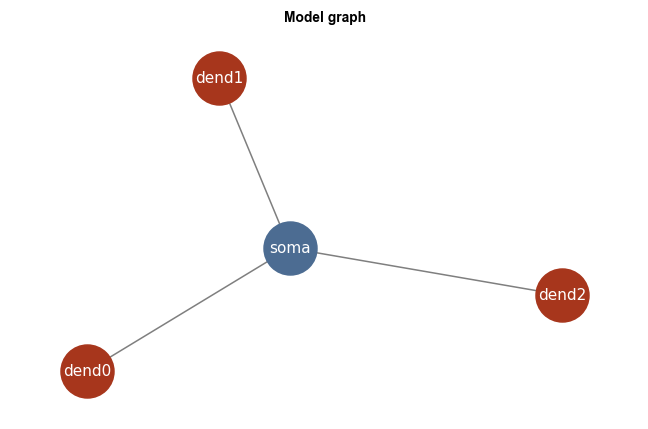

In [35]:
model.as_graph()

WARNING    The name "E_AMPA" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_2". Will use the object from the group-specific namespace with the value 0. * volt, but the name also refers to a variable in the run namespace with value '0. * volt'. [brian2.groups.group.Group.resolve.resolution_conflict]


Running simulation with dt = 0.025 ms


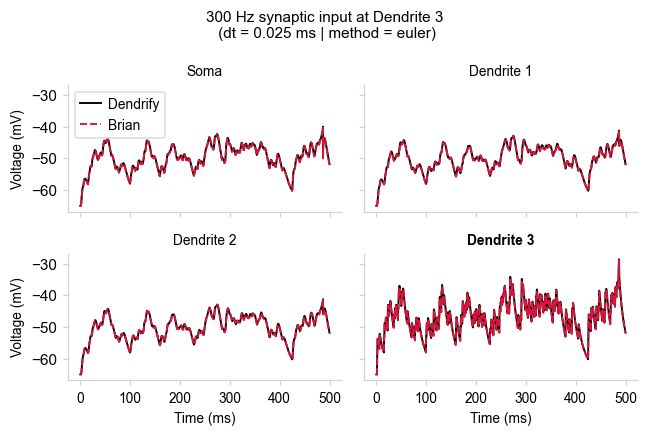

Running simulation with dt = 0.050 ms


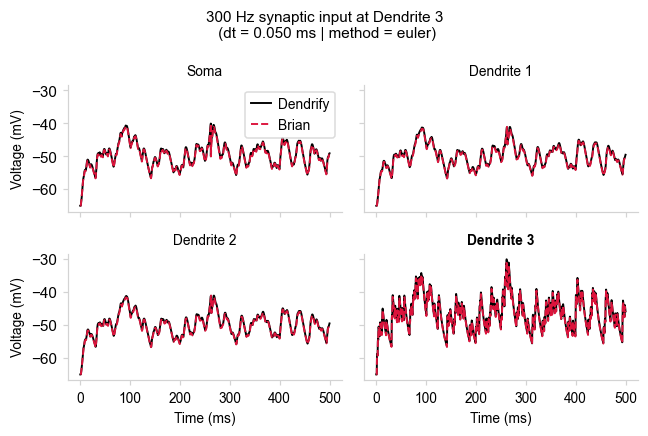

Running simulation with dt = 0.075 ms


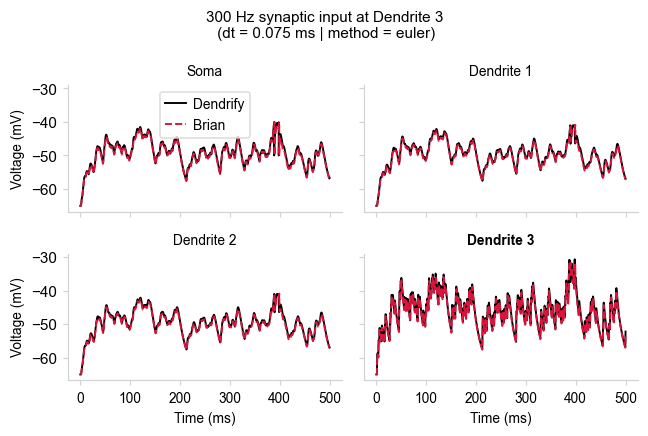

Running simulation with dt = 0.100 ms


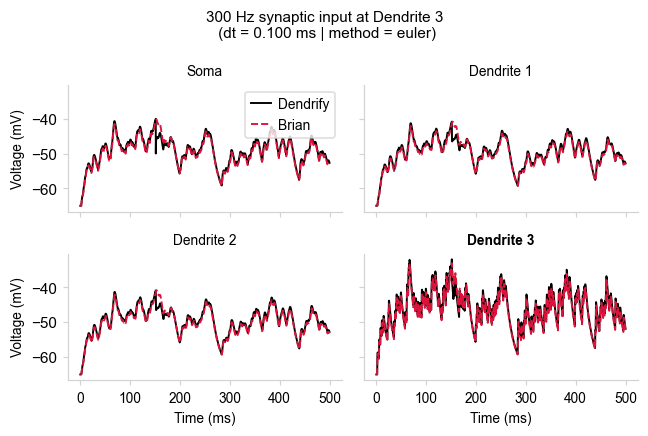

Running simulation with dt = 0.125 ms


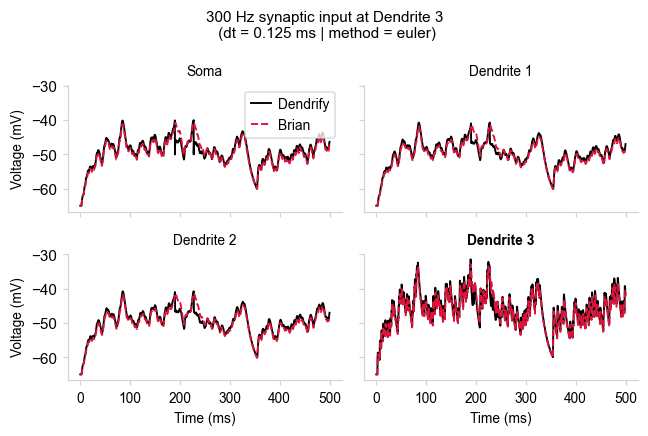

Running simulation with dt = 0.150 ms


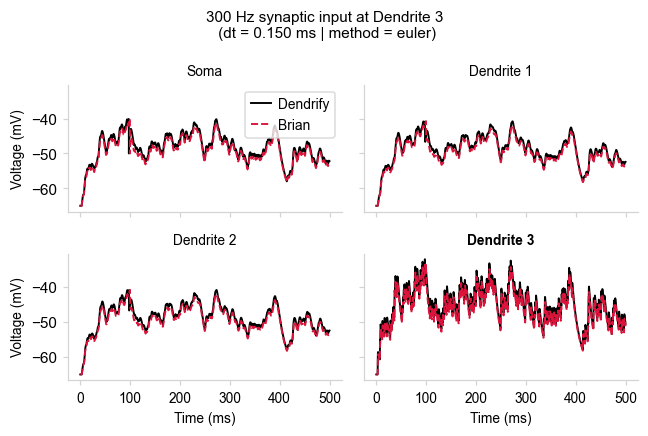

Running simulation with dt = 0.175 ms


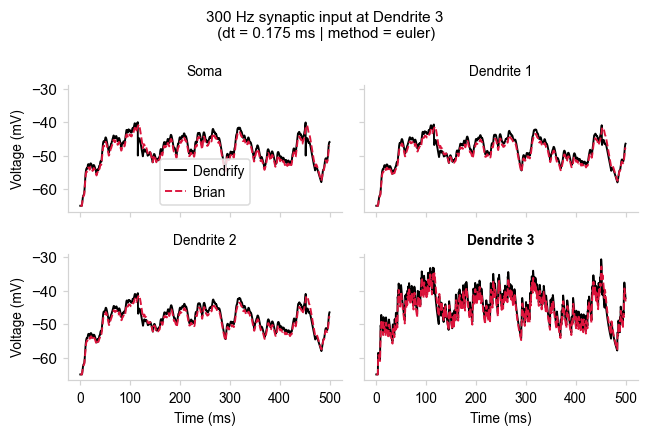

Running simulation with dt = 0.200 ms


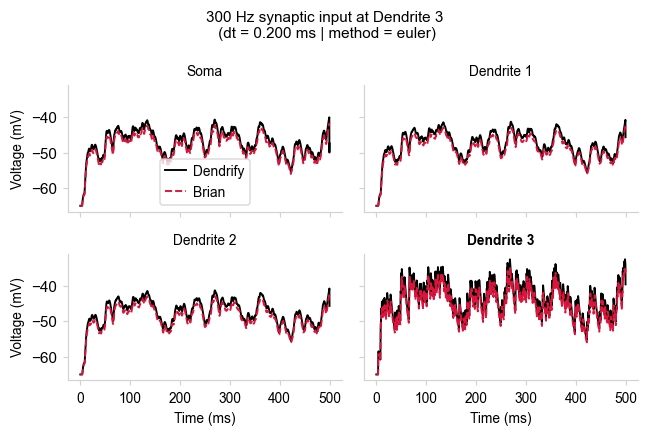

Running simulation with dt = 0.225 ms


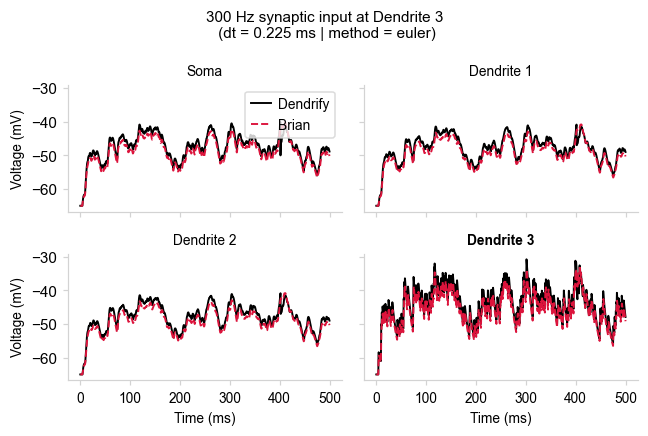

Running simulation with dt = 0.250 ms


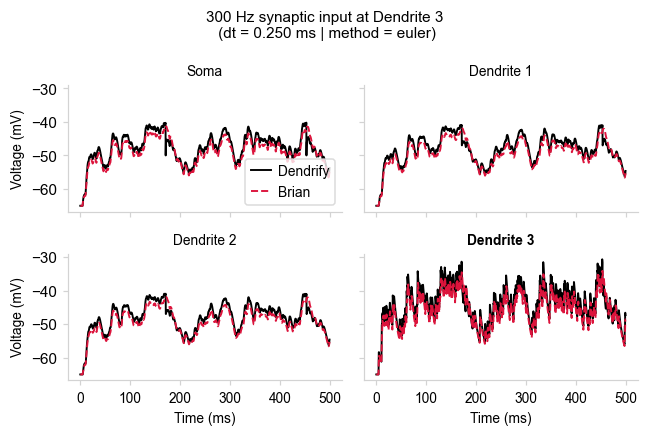

Running simulation with dt = 0.275 ms


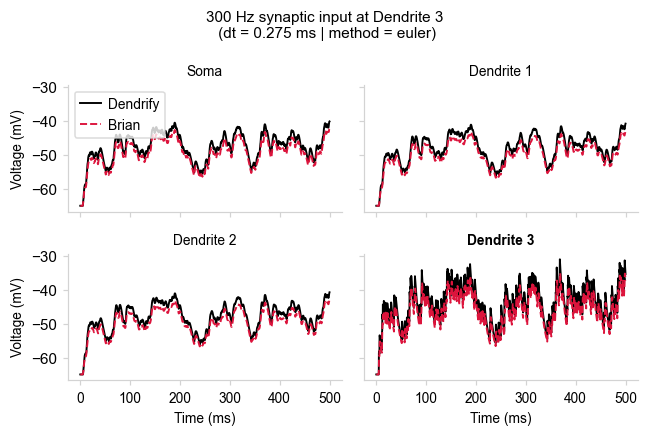

Running simulation with dt = 0.300 ms


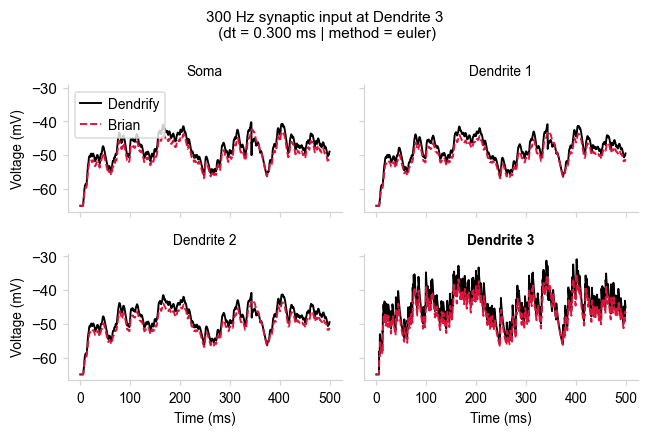

Running simulation with dt = 0.325 ms


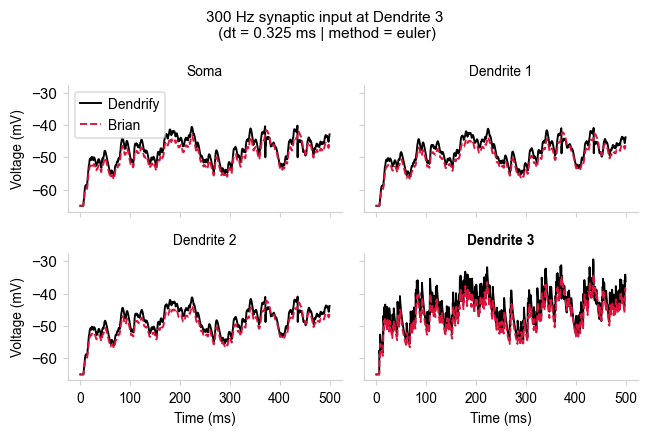

Running simulation with dt = 0.350 ms


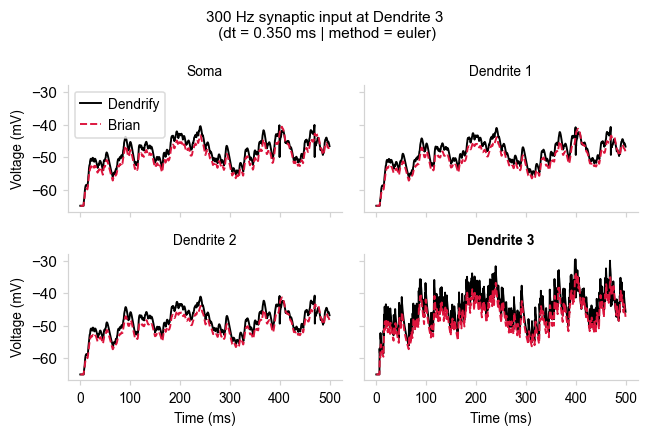

Running simulation with dt = 0.375 ms


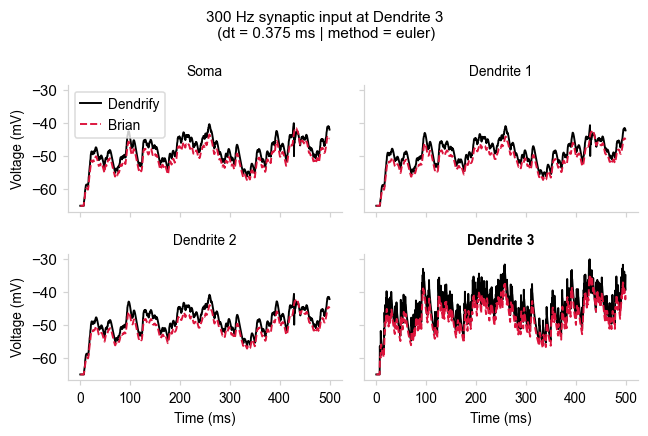

Running simulation with dt = 0.400 ms


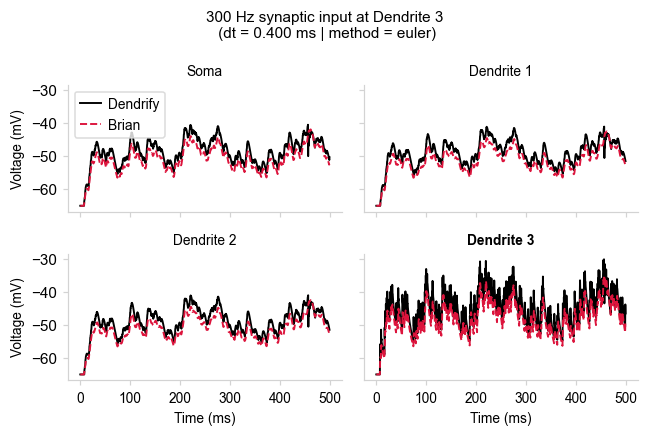

Running simulation with dt = 0.425 ms


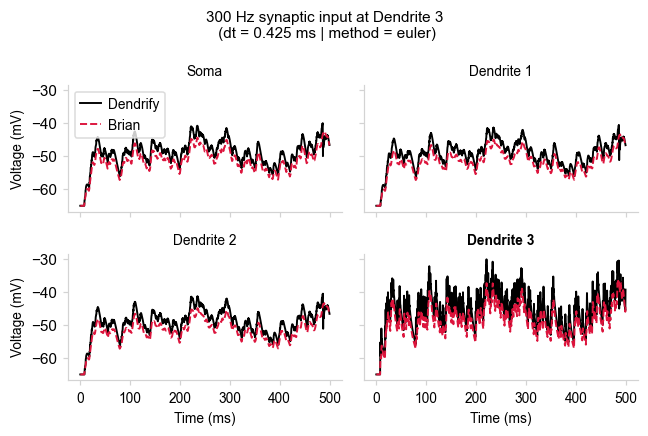

In [36]:
# Run simulation
b.store()
for DT in b.linspace(0.025, 0.425, 17):
    b.seed(1234)
    print(f"Running simulation with dt = {DT:.3f} ms")
    b.restore()
    b.defaultclock.dt = DT * ms

    b.run(500*ms)

    # Plotting
    time = M.t/ms

    # Dendrify:
    Vs = M.V_soma[0]/mV
    Vd0 = M.V_dend0[0]/mV
    Vd1 = M.V_dend1[0]/mV
    Vd2 = M.V_dend2[0]/mV

    # SpatialNeuron
    vs = M_soma[0].v/mV
    vd0 = M_dend0[0].v/mV
    vd1 = M_dend1[0].v/mV
    vd2 = M_dend2[0].v/mV

    fig, ((ax0, ax1), (ax2, ax3)) = b.subplots(2, 2, sharex=True, sharey=True)
    fig.suptitle(
        f'300 Hz synaptic input at Dendrite 3\n (dt = {DT:.3f} ms | method = {INTEGRATION_METHOD})')

    ax0.set_title('Soma')
    ax0.plot(time, Vs, c='black', label='Dendrify')
    ax0.plot(time, vs, c="crimson", ls="--", label='Brian')
    ax0.legend()
    ax0.set_ylabel('Voltage (mV)')

    ax1.set_title('Dendrite 1')
    ax1.plot(time, Vd0, c='black', label='Dendrify')
    ax1.plot(time, vd0, c="crimson", ls="--", label='Brian')

    ax2.set_title('Dendrite 2')
    ax2.plot(time, Vd1, c='black', label='Dendrify')
    ax2.plot(time, vd1, c="crimson", ls="--", label='Brian')
    ax2.set_ylabel('Voltage (mV)')
    ax2.set_xlabel('Time (ms)')

    ax3.set_title('Dendrite 3', fontweight='bold')
    ax3.plot(time, Vd2, c='black', label='Dendrify')
    ax3.plot(time, vd2, c="crimson", ls="--", label='Brian')
    ax3.set_xlabel('Time (ms)')

    fig.tight_layout()
    b.show()